In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [2]:
cnmfe_file_key = pd.read_csv('/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/cnmfe_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [3]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['29-Jan_12_35_06_out.mat','30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['30-Jan_16_54_31_out.mat','30-Jan_14_00_19_out.mat','31-Jan_01_43_49_out.mat','31-Jan_00_12_24_out.mat','31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [4]:
tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [5]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [6]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## triggered averaging 

In [7]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
#bin recording periods by mouse velocity 
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [8]:
V_df.head()

index  miniscope_light  tail_base  \
GRIN039_H12_M26_S54 00:00:00         10.01         2.855264   2.171160   
                    00:00:00.200000  12.69         2.728127   2.149969   
                    00:00:00.400000  15.37         2.600990   2.128777   
                    00:00:00.600000  18.05         2.473853   2.107586   
                    00:00:00.800000  20.73         2.346716   2.086394   

                                     ear_left  centroid  ear_right  \
GRIN039_H12_M26_S54 00:00:00         2.233086  2.058301   2.024822   
                    00:00:00.200000  2.264927  2.006667   2.008735   
                    00:00:00.400000  2.296769  1.955033   1.992648   
                    00:00:00.600000  2.328611  1.903400   1.976562   
                    00:00:00.800000  2.360452  1.851766   1.960475   

                                     miniscope_light_likelihood  \
GRIN039_H12_M26_S54 00:00:00                                1.0   
                    00:00:00.200000                         1.0   
                    00:00:00.400000                         1.0   
                    00:00:00.600000                         1.0   
                    00:00:00.800000                         1.0   

                                     tail_base_likelihood  \
GRIN039_H12_M26_S54 00:00:00                          1.0   
                    00:00:00.200000                   1.0   
                    00:00:00.400000                   1.0   
                    00:00:00.600000                   1.0   
                    00:00:00.800000                   1.0   

                                     ear_left_likelihood  centroid_likelihood  \
GRIN039_H12_M26_S54 00:00:00                    0.999998             1.000000   
                    00:00:00.200000             0.999968             0.999992   
                    00:00:00.400000             0.999937             0.999983   
                    00:00:00.600000             0.999907             0.999975   
                    00:00:00.800000             0.999876             0.999967   

                                     ear_right_likelihood  msCam_index  \
GRIN039_H12_M26_S54 00:00:00                     1.000000          3.0   
                    00:00:00.200000              0.999998          7.0   
                    00:00:00.400000              0.999997         11.0   
                    00:00:00.600000              0.999995         15.0   
                    00:00:00.800000              0.999993         19.0   

                                        velocity_bins  
GRIN039_H12_M26_S54 00:00:00         (-0.0671, 2.294]  
                    00:00:00.200000  (-0.0671, 2.294]  
                    00:00:00.400000  (-0.0671, 2.294]  
                    00:00:00.600000  (-0.0671, 2.294]  
                    00:00:00.800000  (-0.0671, 2.294]

In [9]:
V_df.loc['GRIN026_H16_M35_S34']

,index,miniscope_light,tail_base,ear_left,centroid,ear_right,miniscope_light_likelihood,tail_base_likelihood,ear_left_likelihood,centroid_likelihood,ear_right_likelihood,msCam_index,velocity_bins
00:00:00,19.1850,0.165001,0.281118,0.139150,0.086676,0.142547,0.005841,0.999999,0.041948,0.334162,0.288862,3.0,"(-0.0671, 2.294]"
00:00:00.200000,25.1650,0.160264,0.289744,0.144505,0.092245,0.145542,0.005809,0.999999,0.041702,0.333417,0.286158,7.0,"(-0.0671, 2.294]"
00:00:00.400000,31.1450,0.155527,0.298371,0.149860,0.097814,0.148536,0.005778,0.999999,0.041457,0.332672,0.283455,11.0,"(-0.0671, 2.294]"
00:00:00.600000,37.1250,0.150790,0.306998,0.155215,0.103383,0.151531,0.005746,0.999999,0.041211,0.331927,0.280751,15.0,"(-0.0671, 2.294]"
00:00:00.800000,43.1050,0.146053,0.315624,0.160570,0.108952,0.154526,0.005714,0.999999,0.040965,0.331182,0.278047,19.0,"(-0.0671, 2.294]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:21:03.200000,980.0675,0.197392,0.262343,0.198186,0.200420,0.667456,0.021941,0.999867,0.115469,0.329394,0.181410,25267.0,"(-0.0671, 2.294]"
00:21:03.400000,984.2775,0.198095,0.262694,0.198357,0.230088,0.766187,0.022248,0.999863,0.116643,0.329047,0.178546,25271.0,"(-0.0671, 2.294]"
00:21:03.600000,988.4875,0.198799,0.263044,0.198528,0.259756,0.864918,0.022554,0.999859,0.117816,0.328700,0.175681,25275.0,"(-0.0671, 2.294]"
00:21:03.800000,992.6975,0.199503,0.263395,0.198699,0.289423,0.963649,0.022861,0.999855,0.118990,0.328353,0.172817,25279.0,"(-0.0671, 2.294]"


In [10]:
#to_save = V_df.loc['GRIN026_H16_M35_S34'].rename(columns={'tail_base':'animal_velocity'})['animal_velocity']

In [11]:
#to_save.iloc[0:6250].to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_animal_velocity_trimmed.csv')

In [12]:
#to_save.iloc[0:6250]

In [13]:
## filters out detected "cells" that are smaller than a given pixel threshold (i.e noise)
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [14]:
#C_df.loc['GRIN026_H16_M35_S34'].dropna(axis=1).to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_cells_f_traces_filtered.csv')

In [15]:
#C_df.loc['GRIN026_H16_M35_S34'].dropna(axis=1)

In [16]:
#filtered_for_analysis['GRIN026_H16_M35_S34'].iloc[:,:]

In [17]:
#filtered_for_analysis['GRIN026_H16_M35_S34'].drop(['msCamFrame'], axis=1).to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_cells_f_traces_filtered.csv')

In [18]:
# should save fluorescence output here to pass along along with velocity data, could just pull out tail base values 
#C_df.head()
#C_df.loc['GRIN026_H16_M35_S34'.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_cells_f_traces.csv')

In [19]:
#bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 3)
                                for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
binned_velocity_df = binned_velocity_df.transpose()

In [16]:
#binned_velocity_df

In [17]:
#plt.plot(binned_velocity_df['GRIN035_H14_M40_S34'])
#plt.show()

In [18]:
#binned_velocity_df

In [19]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
#ax1.plot(binned_velocity_df['GRIN013_H13_M33_S54'].values)
#ax2.plot(V_df.loc['GRIN013_H13_M33_S54']['tail_base'].values)
#plt.show()

In [20]:
## get velocity threshold indicies and select fluorescence regions
triggered_activity_across_sessions = {}
triggered_activity_all_cells = {}
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)
    f_threshold_activity = utils_jjm.average_triggered_regions(cell_fluorescence.mean(axis=1).values, crossing_indicies, 80)
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, f_threshold_activity], axis=1, keys=['velocity', 'fluorescence'])
    f_thresholds_cell = {}
    for cell in cell_fluorescence:
        f_thresholds_cell[cell_fluorescence[cell].name] = utils_jjm.average_triggered_regions(cell_fluorescence[cell].values, crossing_indicies, 80)
    triggered_activity_all_cells[session] = pd.concat(list(f_thresholds_cell.values()), axis=1, keys=list(f_thresholds_cell.keys()))

# all cells averaged together
triggered_activity_across_sessions_df = pd.concat(triggered_activity_across_sessions, axis=1)
# all cells individual
triggered_activity_all_cells_df = pd.concat(triggered_activity_all_cells, axis=1)

In [21]:
# velocity and fluorescence events, averaged over all cells in session, for each event in session
#triggered_activity_across_sessions_df.head()
#triggered_activity_across_sessions_df.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_events_velocity_wt.csv')

In [22]:
# fluorescence events, averaged over all cells 
#triggered_activity_all_cells_df.head()
#triggered_activity_all_cells_df.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_events_cell_fluorescence_wt.csv')

## display averaged data

In [23]:
# create range scaled data to compare across cells
scaler = MinMaxScaler()
activity_scaled = pd.DataFrame(scaler.fit_transform(triggered_activity_across_sessions_df), columns=triggered_activity_across_sessions_df.columns)

In [24]:
activity_scaled.head()

GRIN039_H12_M26_S54                                                    \
             velocity                                                     
                 1097      2097      2644      3297      5522      5798   
0            0.053852  0.005708  0.014068  0.068507  0.007272  0.226826   
1            0.051561  0.006628  0.013460  0.080900  0.006303  0.173490   
2            0.049271  0.007547  0.011399  0.093293  0.005333  0.124001   
3            0.046980  0.007777  0.009337  0.096391  0.004790  0.129129   
4            0.041613  0.006125  0.007275  0.084760  0.005358  0.134257   

                                           ... GRIN035_H14_M40_S34            \
                                           ...            velocity             
       5913      6412      7620      8471  ...                1012      3536   
0  0.019103  0.004526  0.007611  0.004690  ...            0.027071  0.007192   
1  0.014753  0.004766  0.007009  0.004722  ...            0.028420  0.007791   
2  0.012127  0.005007  0.006407  0.004755  ...            0.029768  0.008390   
3  0.014427  0.005067  0.005805  0.004787  ...            0.030105  0.008989   
4  0.016726  0.004905  0.005203  0.004795  ...            0.028427  0.009323   

                                                                            \
                      fluorescence                                           
       4516      5643         136       578       1012      3536      4516   
0  0.001231  0.051032     0.189728  0.891939  0.166707  0.074252  0.117846   
1  0.001595  0.052312     0.166084  0.668920  0.135407  0.052987  0.310368   
2  0.001959  0.053593     0.130012  0.530866  0.109931  0.080734  0.285276   
3  0.002323  0.054873     0.100663  0.379824  0.806101  0.059896  0.215123   
4  0.002414  0.056153     0.142822  0.295975  1.000000  0.060323  0.216296   

             
             
       5643  
0  0.758470  
1  0.783512  
2  0.854493  
3  0.844659  
4  1.000000  

[5 rows x 131 columns]

# display individual cell data 

In [25]:
## could save here 
# this data frame contains the activity for all cells, organized by movement event periods in each session
triggered_activity_all_cells_df['GRIN026_H16_M35_S34'].head()

1                                                 2             \
       902       1112      3807      5448      5777      902       1112   
0 -0.715473 -0.508238 -0.412488  0.153889 -0.224369 -0.645371 -0.592759   
1 -0.679464 -0.522337 -0.545745  0.042282 -0.121881 -0.647717 -0.597356   
2 -0.510954 -0.534318 -0.115801  0.158773 -0.220702 -0.648703 -0.602911   
3 -0.222268 -0.505432 -0.243079  0.216253 -0.361516 -0.649119 -0.607873   
4 -0.310930 -0.519953 -0.262700 -0.007538 -0.320139 -0.649293 -0.612306   

                                 ...        84                                \
       3807      5448      5777  ...      902       1112      3807      5448   
0 -0.623397  0.221391  0.147433  ... -0.489693  1.090881  0.643439 -0.507155   
1 -0.639495  0.781583  0.062918  ... -0.498455  0.463782  0.169009 -0.141913   
2 -0.612768  0.343647 -0.012633  ... -0.502821 -0.216787  1.127614 -0.374999   
3 -0.620617  0.572448 -0.080172  ... -0.504996  1.060031  0.746048 -0.473081   
4 -0.638435  0.432355 -0.140547  ... -0.506079  0.469328  0.229308 -0.498370   

                   85                                          
       5777      902       1112      3807      5448      5777  
0  1.360337  0.085520  1.139437  0.478359  1.319918  0.193256  
1  0.740617 -0.035322  1.126668  0.253733  1.254406  0.170655  
2  0.221693  0.406973  1.009418  0.478532  1.231351 -0.205284  
3  0.989243  0.264828  0.864388  0.233414  1.746670  0.043566  
4  0.740671  0.200079  0.731299  0.375054  0.464010  0.752470  

[5 rows x 375 columns]

In [26]:
## could save here 
# this data frame contains the velocity values, and the fluoresence averaged across cells, for each event period in each session
triggered_activity_across_sessions_df.head()

GRIN039_H12_M26_S54                                                    \
             velocity                                                     
                 1097      2097      2644      3297      5522      5798   
0            1.231612  0.091677  0.128645  0.892276  0.241687  1.039767   
1            1.188818  0.097096  0.126258  1.037126  0.222506  0.835284   
2            1.146024  0.102514  0.118164  1.181976  0.203325  0.645546   
3            1.103229  0.103869  0.110069  1.218189  0.192575  0.665207   
4            1.002963  0.094133  0.101975  1.082245  0.203816  0.684867   

                                           ... GRIN035_H14_M40_S34            \
                                           ...            velocity             
       5913      6412      7620      8471  ...                1012      3536   
0  0.293580  0.207114  1.086147  0.308631  ...            0.240742  0.168220   
1  0.257054  0.209753  1.018571  0.308929  ...            0.248452  0.174066   
2  0.235008  0.212392  0.950995  0.309226  ...            0.256162  0.179913   
3  0.254316  0.213052  0.883419  0.309524  ...            0.258090  0.185759   
4  0.273623  0.211278  0.815842  0.309598  ...            0.248496  0.189022   

                                                                            \
                      fluorescence                                           
       4516      5643         136       578       1012      3536      4516   
0  0.108827  0.342754    -0.052763  0.570161 -0.133252 -0.086256  0.746579   
1  0.115418  0.348990    -0.081193  0.372983 -0.152622 -0.103670  1.508911   
2  0.122010  0.355226    -0.124565  0.250925 -0.168388 -0.080949  1.409552   
3  0.128602  0.361462    -0.159855  0.117385  0.262438 -0.098012  1.131767   
4  0.130250  0.367698    -0.109163  0.043251  0.382433 -0.097663  1.136412   

             
             
       5643  
0  0.237182  
1  0.253630  
2  0.300250  
3  0.293791  
4  0.395819  

[5 rows x 131 columns]

In [27]:
#list(triggered_activity_across_sessions.keys())

In [28]:
# create range scaled data to compare across cells
scaler = MinMaxScaler()
activity_scaled = pd.DataFrame(scaler.fit_transform(triggered_activity_all_cells_df), columns=triggered_activity_all_cells_df.columns)
activity_scaled_cell_means = activity_scaled.groupby(level=[0,1], axis=1).mean()

In [29]:
sessions = list(set([column[0] for column in activity_scaled_cell_means.columns]))
print(sessions)

['GRIN033_H13_M42_S33', 'GRIN032_H17_M30_S22', 'GRIN034_H16_M13_S22', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22', 'GRIN039_H12_M26_S54', 'GRIN035_H14_M40_S34', 'GRIN033_H14_M34_S32', 'GRIN027_H13_M29_S44', 'GRIN013_H13_M33_S54', 'GRIN034_H19_M0_S18', 'GRIN035_H13_M31_S20', 'GRIN035_H13_M50_S58']


In [30]:
activity_scaled_cell_means['GRIN026_H16_M35_S34'].head()

,1,2,3,4,5,6,7,8,9,10,...,72,73,74,75,79,81,82,83,84,85
0,0.066210,0.057390,0.058824,0.060657,0.038314,0.024115,0.229775,0.210771,0.028804,0.024677,...,0.038639,0.331315,0.103015,0.295799,0.019507,0.074586,0.279794,0.106330,0.266895,0.363994
1,0.066740,0.076932,0.070547,0.045735,0.037617,0.020249,0.177509,0.224366,0.044296,0.066767,...,0.029756,0.192623,0.099991,0.200437,0.037702,0.062023,0.136144,0.167202,0.186974,0.341204
2,0.121893,0.056821,0.132046,0.037894,0.059942,0.058888,0.166758,0.246476,0.031028,0.090614,...,0.014961,0.135280,0.090051,0.136037,0.039852,0.103505,0.199497,0.178952,0.161226,0.381145
3,0.178289,0.063896,0.096021,0.056212,0.046566,0.050904,0.179065,0.261910,0.038601,0.067769,...,0.018650,0.103112,0.093828,0.202912,0.085951,0.069917,0.066693,0.148956,0.243418,0.361483
4,0.148848,0.054913,0.066982,0.035450,0.028589,0.026937,0.150978,0.270327,0.032900,0.031002,...,0.011905,0.108574,0.090078,0.201628,0.029167,0.089226,0.037345,0.153665,0.177132,0.334076


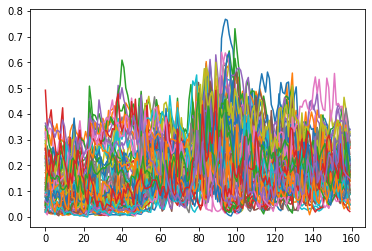

In [31]:
plt.plot(activity_scaled_cell_means['GRIN026_H16_M35_S34'])
plt.show()

In [32]:
# now i want to find the latency from the threshold crossing and sort the events in that manner 

In [33]:
threshold_pt = activity_scaled_cell_means.shape[0]/2

In [34]:
latency = activity_scaled_cell_means.idxmax(axis=0)
latency_flat = latency.reset_index()
latency_sorted = latency_flat.sort_values(by=0)

In [35]:
sorted_heatmap = np.empty([activity_scaled_cell_means.shape[1], activity_scaled_cell_means.shape[0]])

In [36]:
#activity_scaled_cell_means['GRIN035_H14_M40_S34'][49]

In [37]:
for row_idx in range(len(list(latency_sorted.index))):
    sorted_heatmap[row_idx] = activity_scaled_cell_means[latency_sorted.loc[list(latency_sorted.index)[row_idx]]['level_0']][latency_sorted.loc[list(latency_sorted.index)[row_idx]]['level_1']]
    

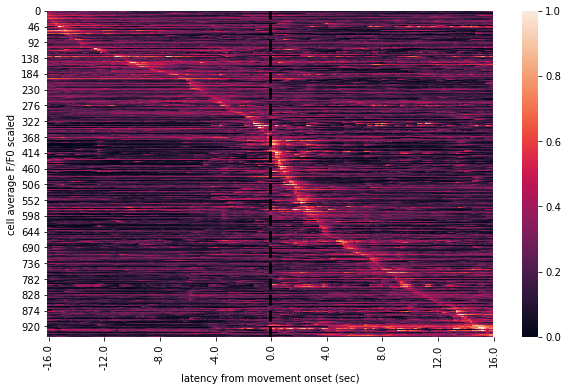

In [38]:
# heatmap

#fluorescence_events = np.transpose(sorted_heatmap)
X_labels = np.linspace(-16, 16, 161)
ax = sns.heatmap(sorted_heatmap, xticklabels=X_labels)
ax.set_xticks(ax.get_xticks()[::20])
ax.set_xticklabels(X_labels[::20])
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cell average F/F0 scaled')
ax.set_xlabel('latency from movement onset (sec)')
ax.axvline(x=(80), linestyle='--', lw=3, color='k')
#fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2021/cell_avg_aligned_heatmap.pdf', transparent=True)
plt.show()


In [39]:
KO_latency = pd.read_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2021/motion_onset_alignment/latency_to_movement_onset_KO.csv').drop(['Unnamed: 0'], axis=1)

In [40]:
KO_latency['0']

0        0
1        0
2        0
3        0
4        0
      ... 
759    159
760    159
761    159
762    159
763    159
Name: 0, Length: 764, dtype: int64

In [41]:
#convert to seconds for display 
latency_sorted[0]*(.2)-(31.8/2)

638   -15.9
948   -15.9
688   -15.9
875   -15.9
706   -15.9
       ... 
169    15.9
72     15.9
591    15.9
365    15.9
950    15.9
Name: 0, Length: 951, dtype: float64

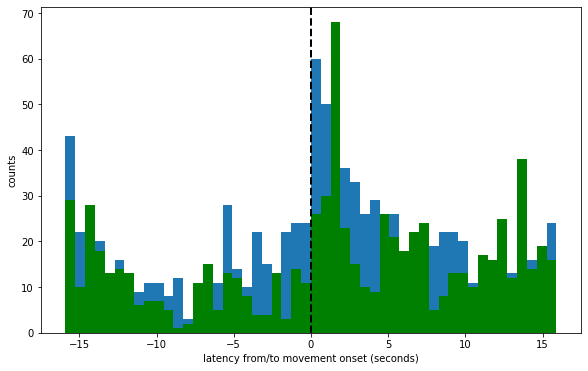

In [42]:
## plot a histogram of the latency to threshold
plt.hist(latency_sorted[0]*(.2)-(31.8/2), 50)
plt.hist(KO_latency['0']*(.2)-(31.8/2), 50, color='g')
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('counts')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(0), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2021/motion_onset_alignment/cumulative_latency_histogram.pdf', transparent=True)
plt.show()

In [43]:
# plot cumulative histogram
cumulative_latency = stats.cumfreq(latency_sorted[0].values, numbins=100, defaultreallimits=(0, 160))
cumulative_latency_KO = stats.cumfreq(KO_latency['0'].values, numbins=100, defaultreallimits=(0, 160))

In [44]:
#cumulative_latency

In [45]:
cumulative_data = cumulative_latency.cumcount/len(latency_sorted[0].values)
cumulative_data_KO = cumulative_latency_KO.cumcount/len(KO_latency['0'].values)

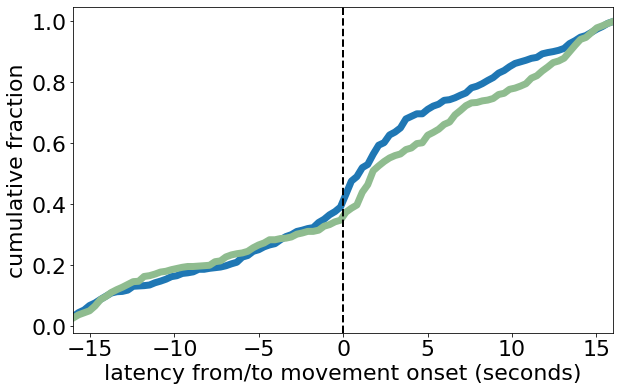

In [46]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(-16, 16, 100), cumulative_data, linewidth=7.0)
plt.plot(np.linspace(-16, 16, 100), cumulative_data_KO, color='darkseagreen', linewidth=7.0)
plt.xlim((-16, 16))
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(0), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2021/motion_onset_alignment/cumulative_latency.pdf', transparent=True)
plt.show()

In [47]:
stats.ks_2samp(cumulative_data, cumulative_data_KO)

Ks_2sampResult(statistic=0.09, pvalue=0.8154147124661313)

In [ ]:
##average together by session 

In [ ]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [ ]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)
resampled_for_plotting = combined_by_mouse_timedelta.resample('.4S').mean()

In [ ]:
#resampled_for_plotting.head()

In [ ]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.4, (len(df_to_plot)/2)*.4, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/v_triggered.pdf', transparent=True)
plt.show()

In [ ]:
activity_measure = 'fluorescence'
x = np.linspace(-(len(df_to_plot)/2)*.4, (len(df_to_plot)/2)*.4, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('dF/F z-score')
ax.set_xlabel('time (seconds)')
ax.set_ylim([-0.02, 1.2])
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/wt_fluorescence_triggered.pdf', transparent=True)
plt.show()

## event ISIs 

In [ ]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))

In [ ]:
C_df = C_df.drop(['msCamFrame'], axis=1)

In [ ]:
ISIs_by_session = []
for session in list(grouped_raw_data.keys()):
    print(session)
    event_indicies, event_times, event_ISIs = utils_jjm.get_ISIs(C_df.loc[session].dropna(axis=1), 20, .1, np.array(C_df.loc[session].dropna(axis=1).columns), 2)
    ISIs_by_session.append(event_ISIs)